# Contexto:
Este conjunto de dados contém informações relevantes de clientes de uma empresa de telecomunicações. Ao todo são 20 características incluindo o Churn

# Fonte:
Esse conjunto de dados foi retirado do <a href="https://www.kaggle.com/datasets/blastchar/telco-customer-churn">Kaggle.</a>

# Objetivo: 
- O meu objetivo nesse projeto é desenvolver um modelo de machine learning focado em retenção de clientes, prevendo se um futuro cliente deixará a empresa(Churn) ou não(Não Churn), para que assim a empresa possa implementar estratégias para manutenção desses clientes, como a aplicação de descontos na fatura.

# Entendendo Features

**CustomerID**: Um ID exclusivo que identifica cada cliente.

**Gender**: Sexo do cliente.

**Age**: Idade atual do cliente, em anos.

**Senior Citizen**:  Indica se o cliente tem 65 anos ou mais.

**Married (Partner)**: Indica se o cliente é casado

**Dependents**: Indica se o cliente mora com algum dependente.

**Phone Service**: Indica se o cliente contrata o serviço telefônico residencial da empresa.

**Multiple Lines**: Indica se o cliente assina múltiplas linhas telefônicas com a empresa.

**Internet Service**: Indica se o cliente assina o serviço de Internet da empresa.

**Online Security**: Indica se o cliente assina algum serviço adicional de segurança online fornecido pela empresa.

**Online Backup**: Indica se o cliente assina algum serviço adicional de backup online fornecido pela empresa.

**Device Protection Plan**:  Indica se o cliente assina um plano adicional de proteção de dispositivos para seus equipamentos de Internet fornecido pela empresa.

**Streaming TV**: Indica se o cliente utiliza seu serviço de Internet para transmitir programação de televisão de um provedor terceirizado.

**Streaming Movies**: Indica se o cliente utiliza seu serviço de Internet para transmitir filmes de um provedor terceirizado

**Paperless Billing**: Indica se o cliente optou pelo faturamento sem papel

**Payment Method**: Indica como o cliente paga sua fatura.

**Monthly Charge**: Indica a cobrança mensal total atual do cliente por todos os serviços da empresa.

**Total Charges**: Indica os encargos totais do cliente.

**Tenure**: Indica o total de meses que o cliente está na empresa.

**Churn**: Indica se o cliente deixou ou não a empresa

# Importando bibliotecas

In [239]:
# Bibliotecas para visualização e manipulação de dados
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Importando modelos e ferramentas para tratamento de dados e validação
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder, WOEEncoder, BinaryEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, confusion_matrix)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Importando ferramenta para tunagem de hiperparâmetros 
import optuna
from optuna.samplers import TPESampler

# Importando ferramente para interpretar modelos 
import shap
shap.initjs()

# Removendo warnings
import warnings
warnings.filterwarnings("ignore")

# Definindo um estilo para os gráficos
mpl.style.use("ggplot")

mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["grid.color"] = "lightgray"
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["axes.grid"] = True
mpl.rcParams["font.size"] = 12

# Importando funções úteis

In [240]:
def set_annotate(fig, h=False, porcentages=False):
    """
    Adiciona anotações aos retângulos em um gráfico de barras.

    Args:
        fig: matplotlib.figure.Figure 
            Objeto figura matplotlib.
        h: bool
            Se verdadeiro, a anotação será horizontal; caso contrário, será vertical.
        porcentage: bool: 
            Se verdadeiro, os valores serão exibidos como porcentagens; caso contrário, como valores brutos.
    """
    
    for ax in fig.get_axes():
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            if width > 0 and height > 0:
                if h:
                    reference = width 
                    xy = (p.get_x() + width, p.get_y() + height / 2)
                    ha="left"
                    va="center"
                else:
                    reference =  height
                    xy = (p.get_x() + width / 2, p.get_y() + height)
                    ha="center"
                    va="bottom"
                if reference < 0.01:
                    text = "{:.2e}".format(reference)
                else:
                    text = "{:.2f}%".format(reference * 100) if porcentages else "{:.2f}".format(reference)
                
                ax.annotate(text, xy=xy, ha=ha, va=va, fontsize=12, color="black", xytext=(5, 0),
                            textcoords="offset points")

In [241]:
def validacao_cruzada(X, y, k, preprocessor, models, return_df=False):
    """
    Avalia o desempenho de uma lista de modelos com a validação cruzada K-Fold 

    X: pd.DataFrame
            Conjunto de dados de entrada (features).
    y: pd.Series
        Labels correspondentes aos dados de entrada.
    k: int 
        Número de folds na validação cruzada.
    preprocessor: Pipeline
        Pipeline de pré-processamento aplicado aos dados antes do treinamento.
    models: list
        Lista de modelos a serem avaliados.
    return_df: bool
        Se True, retorna um DataFrame com as avaliações dos modelos; caso contrário, retorna um dicionário.
    """
    
    modelos_scores = {}

    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for model in models:
        accuracy, precision, recall, f1, roc_auc, logloss = [], [], [], [], [], []

        for k, (train_index, test_index) in enumerate(folds.split(X, y)):
            X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
            X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        

            pipe = Pipeline(steps=[
                ("preprocessor", preprocessor),   
                ("classifier", model)
            ])
            
            pipe.fit(X_train_interno, y_train_interno)

            y_pred = pipe.predict(X_test_interno)
            y_prob = pipe.predict_proba(X_test_interno) 
            
            accuracy.append(accuracy_score(y_test_interno, y_pred))
            precision.append(precision_score(y_test_interno, y_pred))
            recall.append(recall_score(y_test_interno, y_pred))
            f1.append(f1_score(y_test_interno, y_pred))
            logloss.append(log_loss(y_test_interno, y_pred))

            if y_prob is not None:
                if len(np.unique(y)) == 2:  # Classificação binária
                    roc_auc.append(roc_auc_score(y_test_interno, y_prob[:, 1]))
                else:  # Classificação multiclasse
                    roc_auc.append(roc_auc_score(y_test_interno, y_prob, multi_class="ovr"))
        

        scores_dict = {
            "Acurácia média": np.mean(accuracy),
            "Precisão média": np.mean(precision),
            "Recall médio": np.mean(recall),
            "F1-Score médio": np.mean(f1),
            "ROC-AUC-Score médio": np.mean(roc_auc),
            "Log Loss": np.mean(logloss)
        }
        modelos_scores[model.__class__.__name__] = scores_dict

    return pd.DataFrame(modelos_scores).T if return_df else modelos_scores

In [242]:
def matriz_de_confusão(classifier, x_test, y_test):
    """
    Avalia o desempenho de um modelo de classificação gerando uma matriz de confusão.

    Args:
        classifier : modelo de classificação treinado
            O modelo de classificação a ser avaliado.
        x_test : pd.DataFrame
            Conjunto de dados de teste (features).
        y_test : pd.Series
            Conjunto de dados de teste (labels verdadeiros).
    """
    
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    
    classificacao = ["Verdadeiro Negativo", "Falso Positivo"
             , "Falso Negativo", "Verdadeiro Positivo"]
    
    posicao = [f"{value}" for value in cm.flatten()]
    porcentagens = [f"{value:.2%}" for value in cm.flatten() / np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(classificacao, posicao, porcentagens)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=labels, cmap="Blues", fmt="", cbar=False, annot_kws={"size": 16})
    plt.xlabel("Valores preditos", fontsize=14)
    plt.ylabel("Valores reais", fontsize=14)
    plt.title("Matriz de Confusão", fontsize=16)

    plt.show()

# Lendo, entendendo e limpando o dataset

In [243]:
customers = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [244]:
customers.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


Optarei por remover a coluna customerID, que é completamente inútil aqui

In [245]:
customers = customers.drop("customerID", axis=1)

In [246]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


<h4>Observações: </h4>
<ul> 
    <li>Há 7043 observações no dataset</li>
    <li>Ao todo, há 19 features no dataset, sendo apenas 3 variáveis numéricas quantitativas, assumindo a conversão de TotalCharges para númerica</li>  
</ul>

Verificando valores nulos: 

In [247]:
for column in customers.select_dtypes(include=["object", "category"]).columns:
    customers[column] = customers[column].replace(" ", np.nan)

customers.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [248]:
customers[customers.TotalCharges.isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [249]:
print(f"Apenas {(len(customers[customers.TotalCharges.isnull()]) / customers.shape[0]) * 100:.2f}% dos clientes possuem TotalCharges nula")

Apenas 0.16% dos clientes possuem TotalCharges nula


Vou optar por substituir os NaNs com a média ou mediana, dependendo a distribuição da feature, seguindo as condições: 

- Se a distribuição for assimétria à direita, usarei a mediana
- Se a distribuição for assimétrica à esquerda, usarei a média

In [250]:
customers["TotalCharges"] = customers["TotalCharges"].astype("float")

In [251]:
customers.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [252]:
customers.describe(include=["object", "category"])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


<h4>Observações: </h4>
<ul> 
    <li>Temos então que a distribuição de TotalCharges é assimétria à direita, pois a sua média é maior que a mediana. Portanto, substituirei os valores faltantes pela mediana</li>
    <li>Tenure, MonthlyCharges e TotalCharges tem desvios significantes</li>  
    <li>A média de meses que um cliente está com a empresa de 32</li>
    <li>A maior parte das pessoas(75%) não tem cobranças mensais que ultrapassam U$ 80</li>
</ul>

# Análise Exploratória

## Análise Univariada

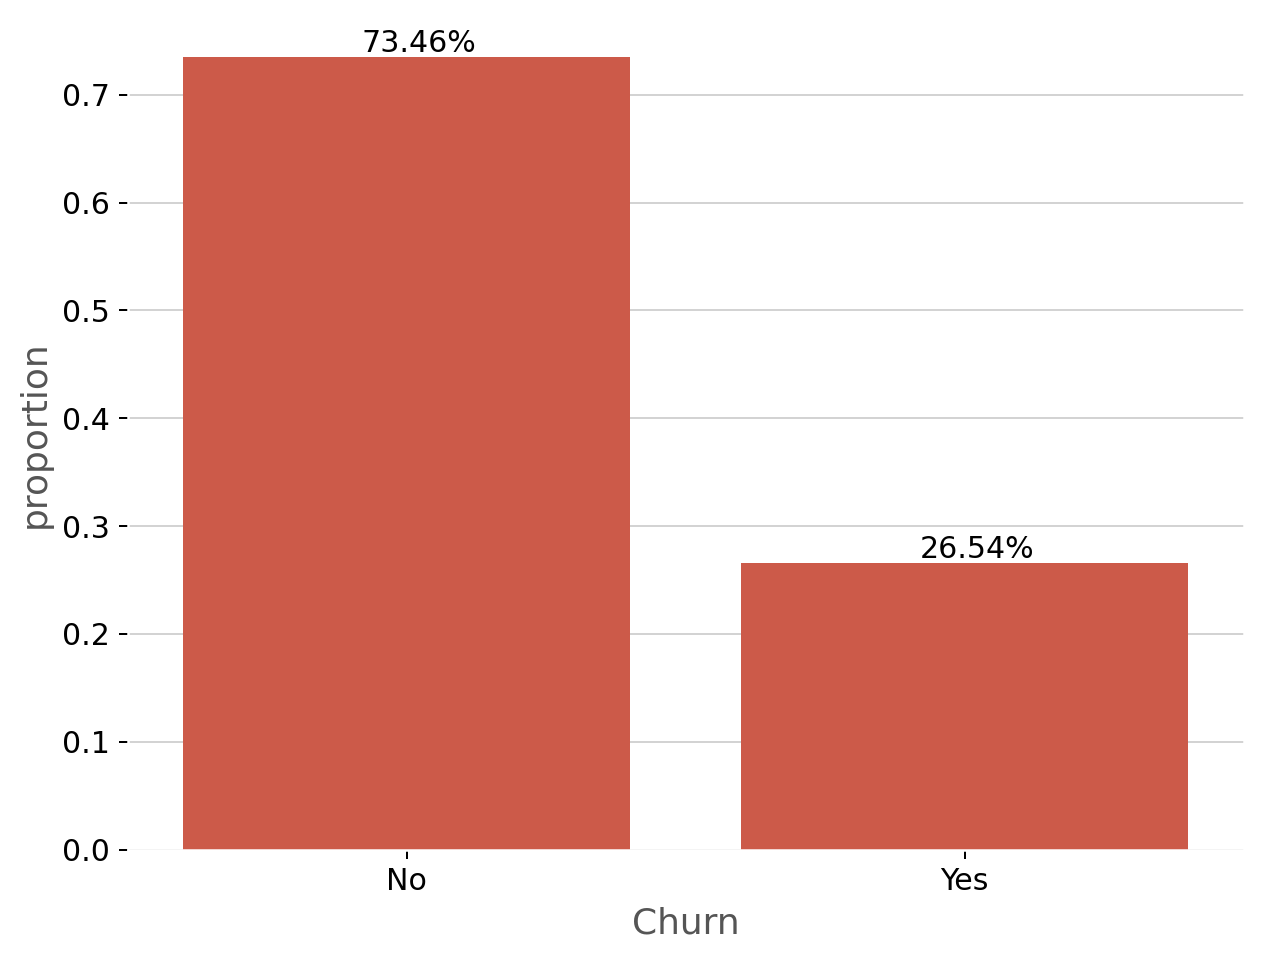

In [253]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(data=customers.Churn.value_counts(normalize=True).reset_index(), x="Churn", y="proportion", ax=ax)

set_annotate(fig=fig, porcentages=True)

<h4>Observações: </h4>
<ul> 
    <li>A taxa de churn é bem significativa, sendo que pouco mais de 1/4 dos clientes tendem a dar churn</li>
</ul>

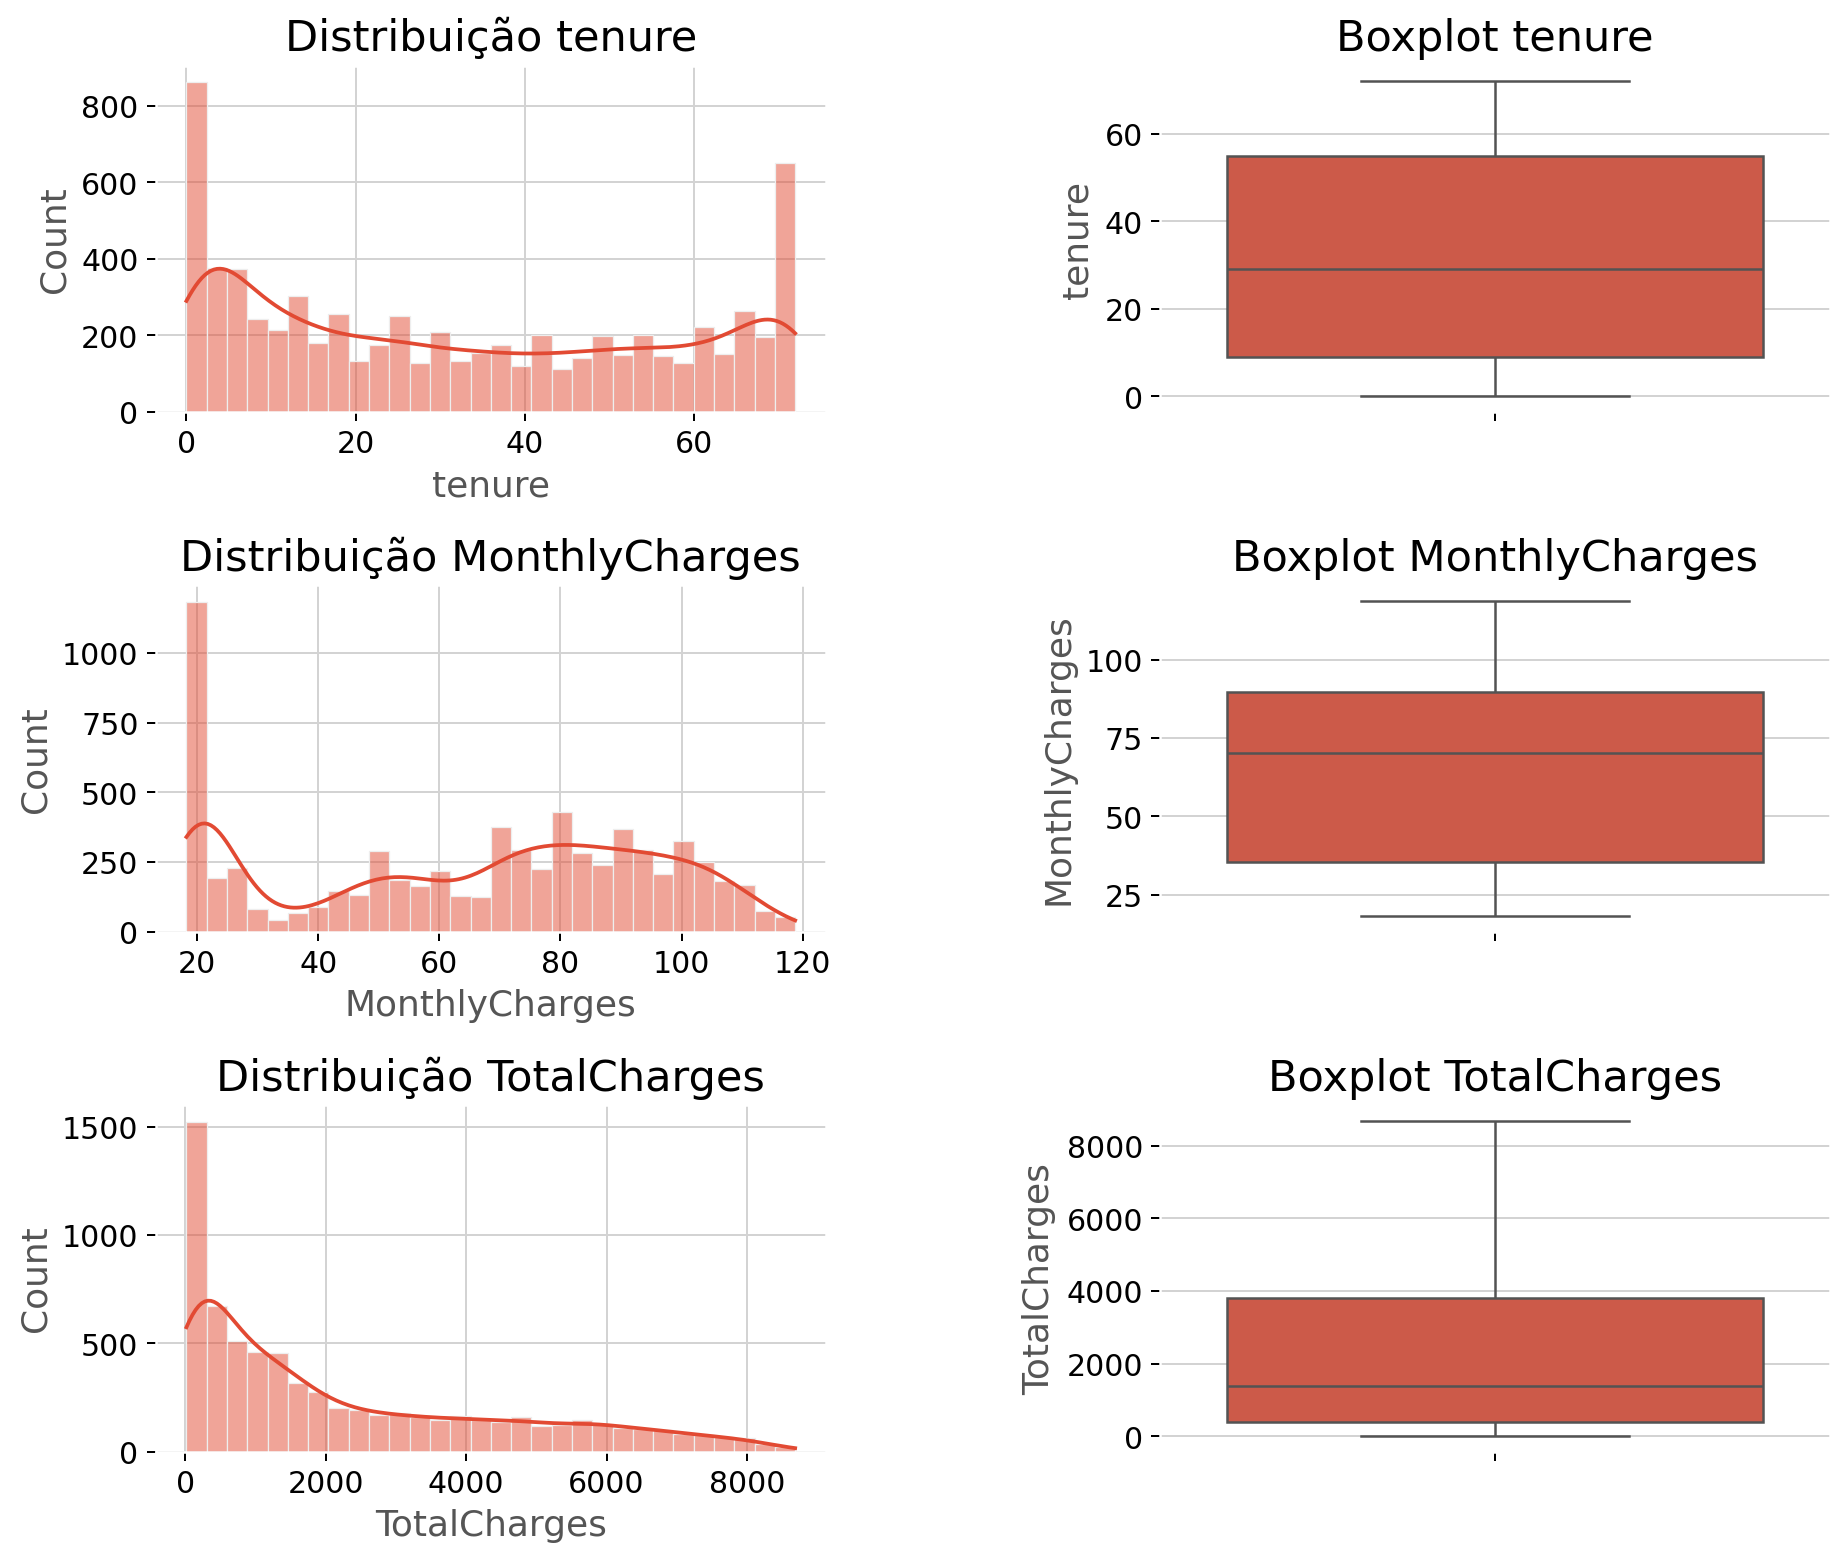

In [254]:
cols = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, ax = plt.subplots(figsize=(12,10), nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)


for i in range(0, 3):    
    col = cols[i]

    sns.histplot(data=customers, x=col, kde=True, bins=30, ax=ax[i][0])
    ax[i][0].set_title(f"Distribuição {col}")

    sns.boxplot(data=customers, y=col, ax=ax[i][1])
    ax[i][1].set_title(f"Boxplot {col}")


<h4>Observações: </h4>
<ul> 
    <li>Não há outliers em nenhuma das três características análisas, mas acima de 75%, os dados estão bem dispersos</li>
    <li>Metade dos clientes tem até 29 meses com a empresa</li>  
    <li>Apenas 25% dos clientes tem um total de cobranças maior de 3800, sendo que metade tem até 1400</li>
</ul>

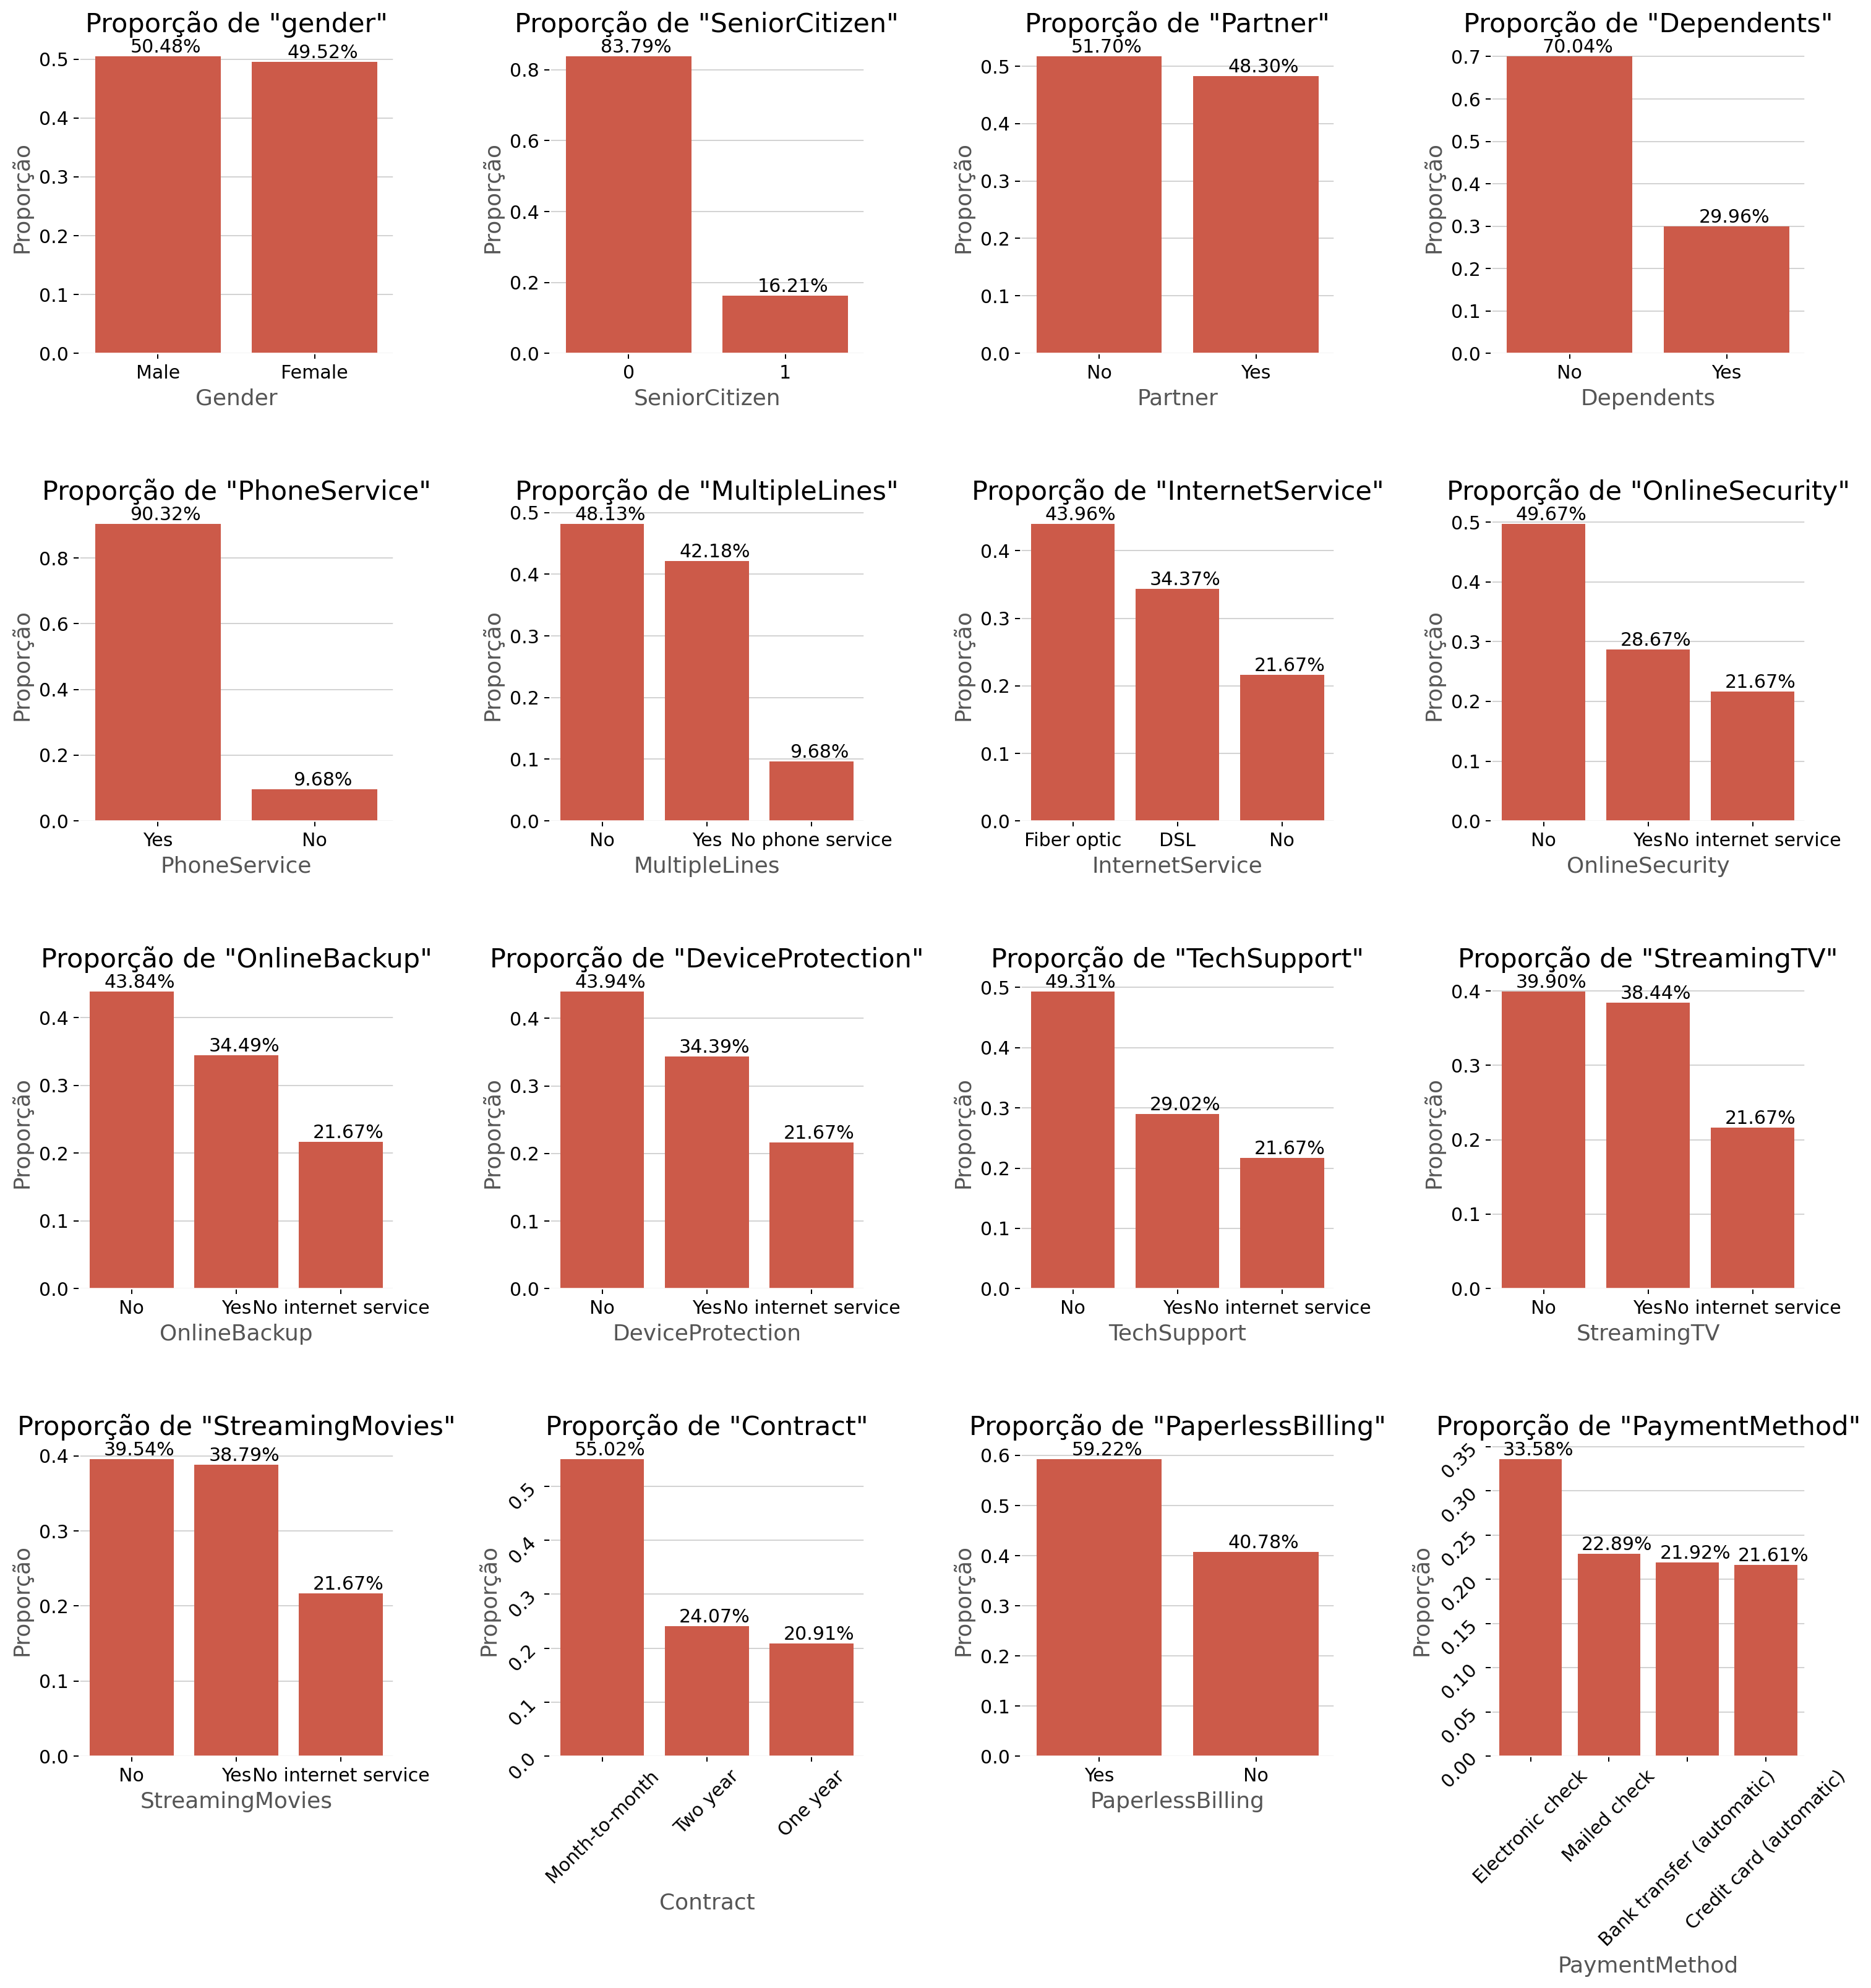

In [255]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
ax = ax.flatten()

for i, col in enumerate(cols):
    sns.barplot(data=customers[col].value_counts(normalize=True).reset_index(), x=col, y="proportion", ax=ax[i])
    ax[i].set_title(f'Proporção de "{col}"')
    ax[i].set_xlabel("".join([col[0].upper(), col[1:]]))
    ax[i].set_ylabel("Proporção")

    if col in ["PaymentMethod", "Contract"]:
        ax[i].tick_params(rotation=45)

set_annotate(fig=fig, porcentages=True)

<h4>Observações: </h4>
<ul> 
    <li>A proporção de homens e mulheres clientes da empresa é bem semelhante</li>
    <li>Quase 84% dos clientes não são idosos</li>  
    <li>A maior parte dos clientes não são casados, com uma proporção pouco maior do que aqueles que tem</li>
    <li>Pouco mais de 21% dos clientes não possuem serviço de internet</li>
    <li>70% dos clientes não possuem dependentes</li>
    <li>Mais de 90% dos clientes possuem serviço de telefone, sendo que a maioria, por uma margem não tão grande, não possui múltiplas linhas</li>
    <li>Quase metade dos clientes não possuem serviços de segurança online, Backup Online, Proteção de dispositivo e suporte técnico</li>
    <li>A proporção de clientes que tem serviços de streaming e a proporção dos que não tem são extremamente semelhantes</li>
    <li>Mais da metade dos clientes optam por um tipo de contrato mensal, sendo que 24% optam pelo tipo de contrato mais longo, ou seja, o de dois anos</li>
    <li>Quase 60% dos clientes optam por faturas desmaterializadas</li>
</ul>

## Análise Bivariada e Multivarada

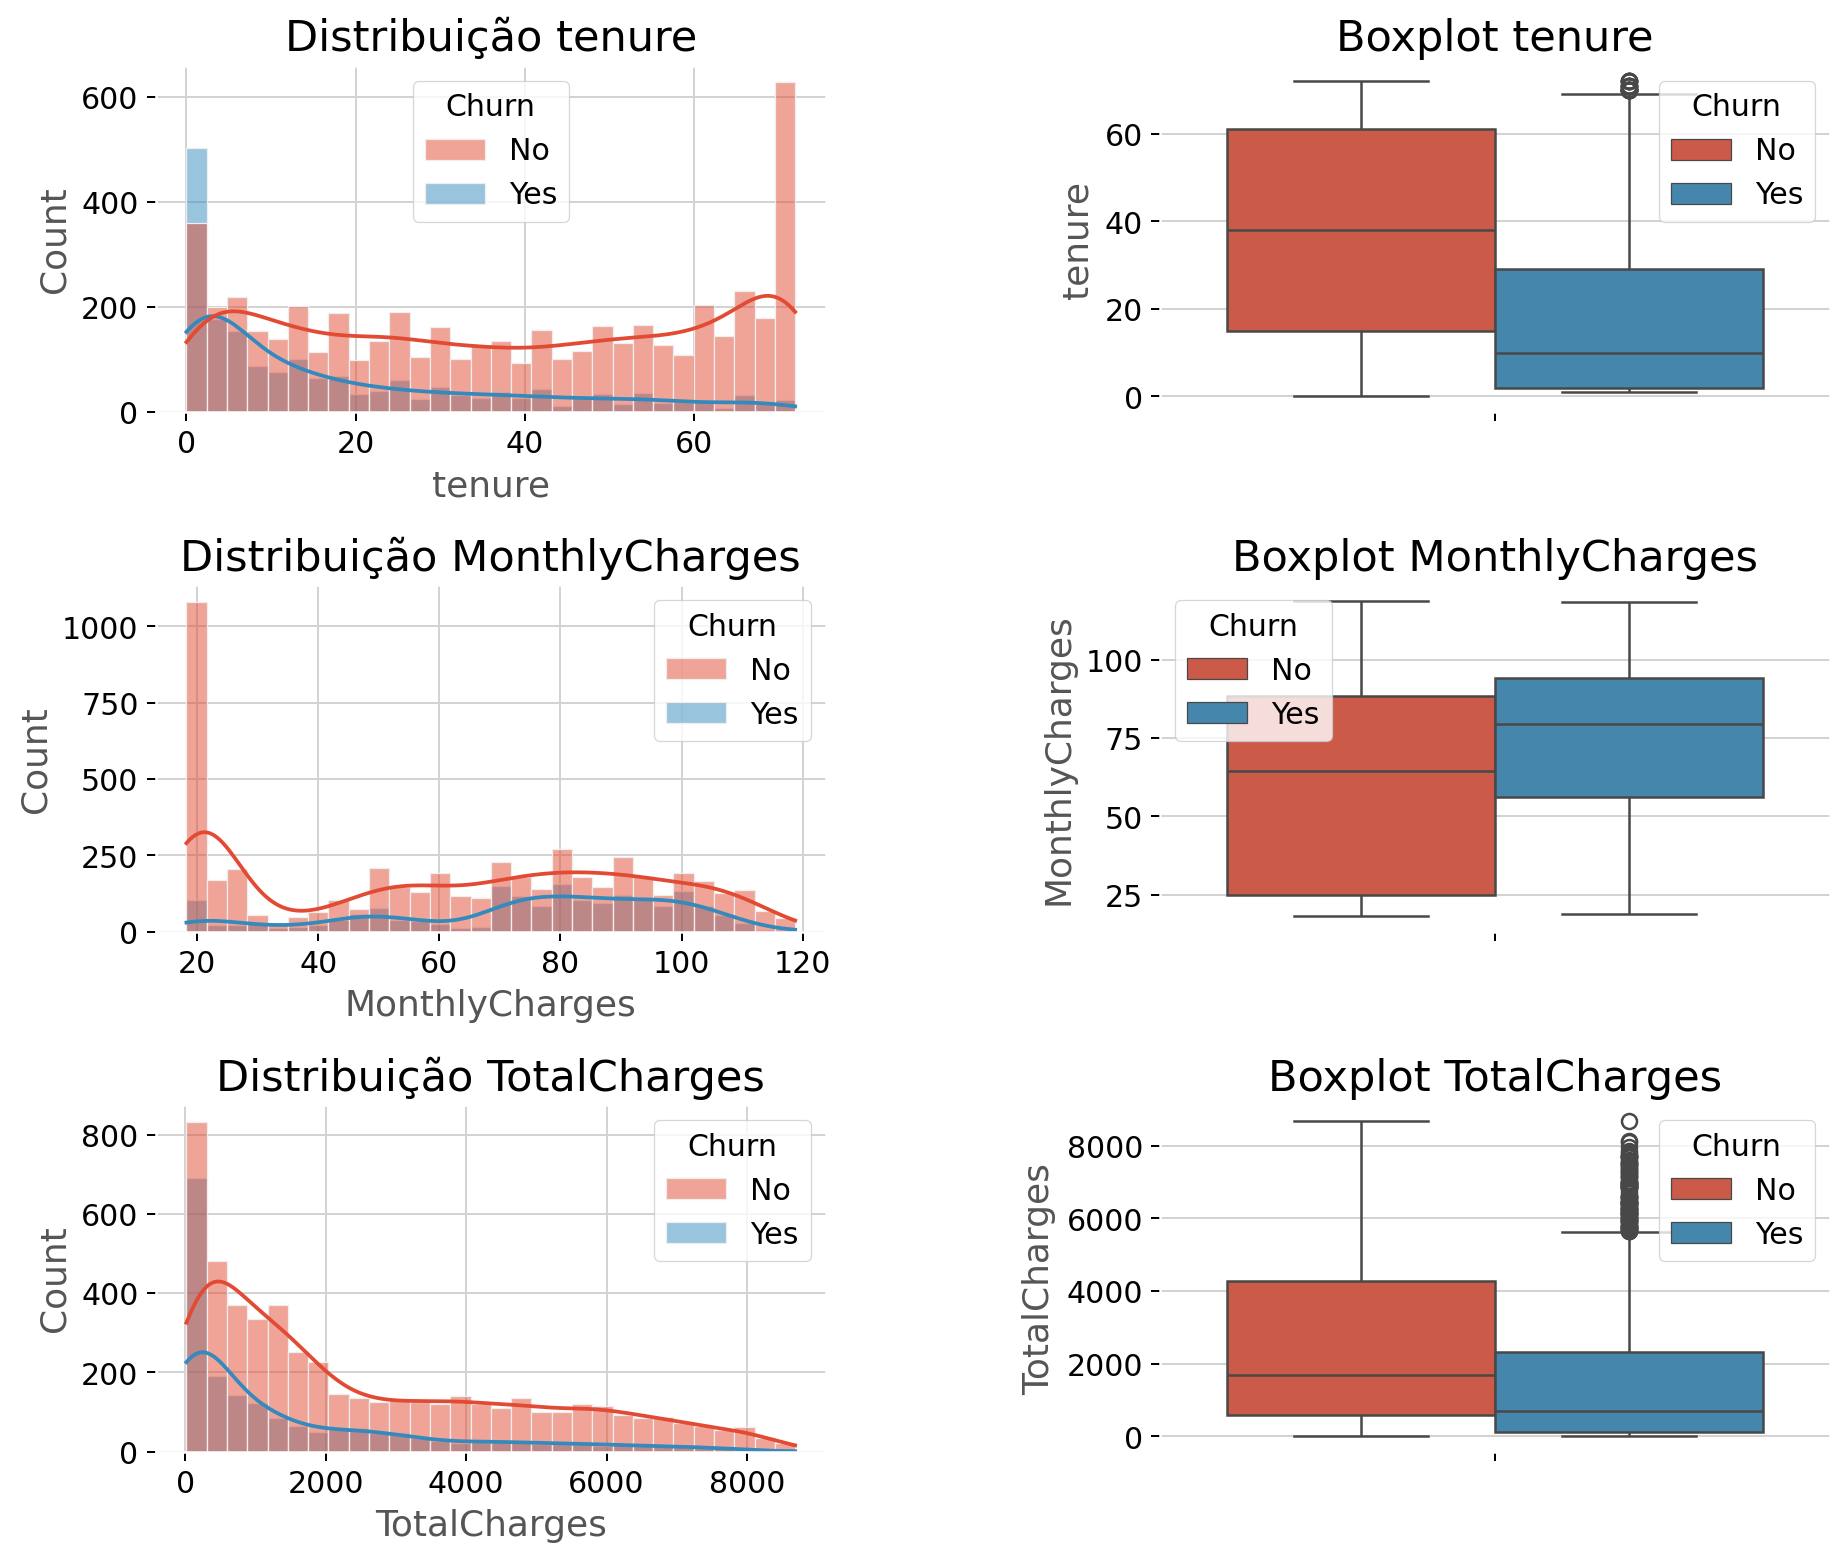

In [256]:
cols = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, ax = plt.subplots(figsize=(12,10), nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)


for i in range(0, 3):    
    col = cols[i]

    sns.histplot(data=customers, x=col, hue="Churn", kde=True, bins=30, ax=ax[i][0])
    ax[i][0].set_title(f"Distribuição {col}")

    sns.boxplot(data=customers, y=col, hue="Churn", ax=ax[i][1])
    ax[i][1].set_title(f"Boxplot {col}")


<h4>Observações: </h4>
<ul> 
    <li>O número de meses que o cliente passa com a empresa tende a ser drásticamente menor entre os que deram churn, sendo que até 50% tende a deixar a empresa por volta do décimo mês
    <li>O valor das cobranças mensais tende a ser maior entre o grupo de clientes que deu churn, onde até 50% dos clientes churn tendem a ter cobranças mensais por volta dos U$ 75</li>  
    <li>As cobranças totais tendem a ser menores entre os clientes que deram churn, sendo outliers aqueles do grupo de churn que chegaram a ter cobranças totais acima dos U$ 6000</li>
    <li>Tenure e MonthlyCharges, particularmente parecem boas features para avaliar o churn</li>
</ul>

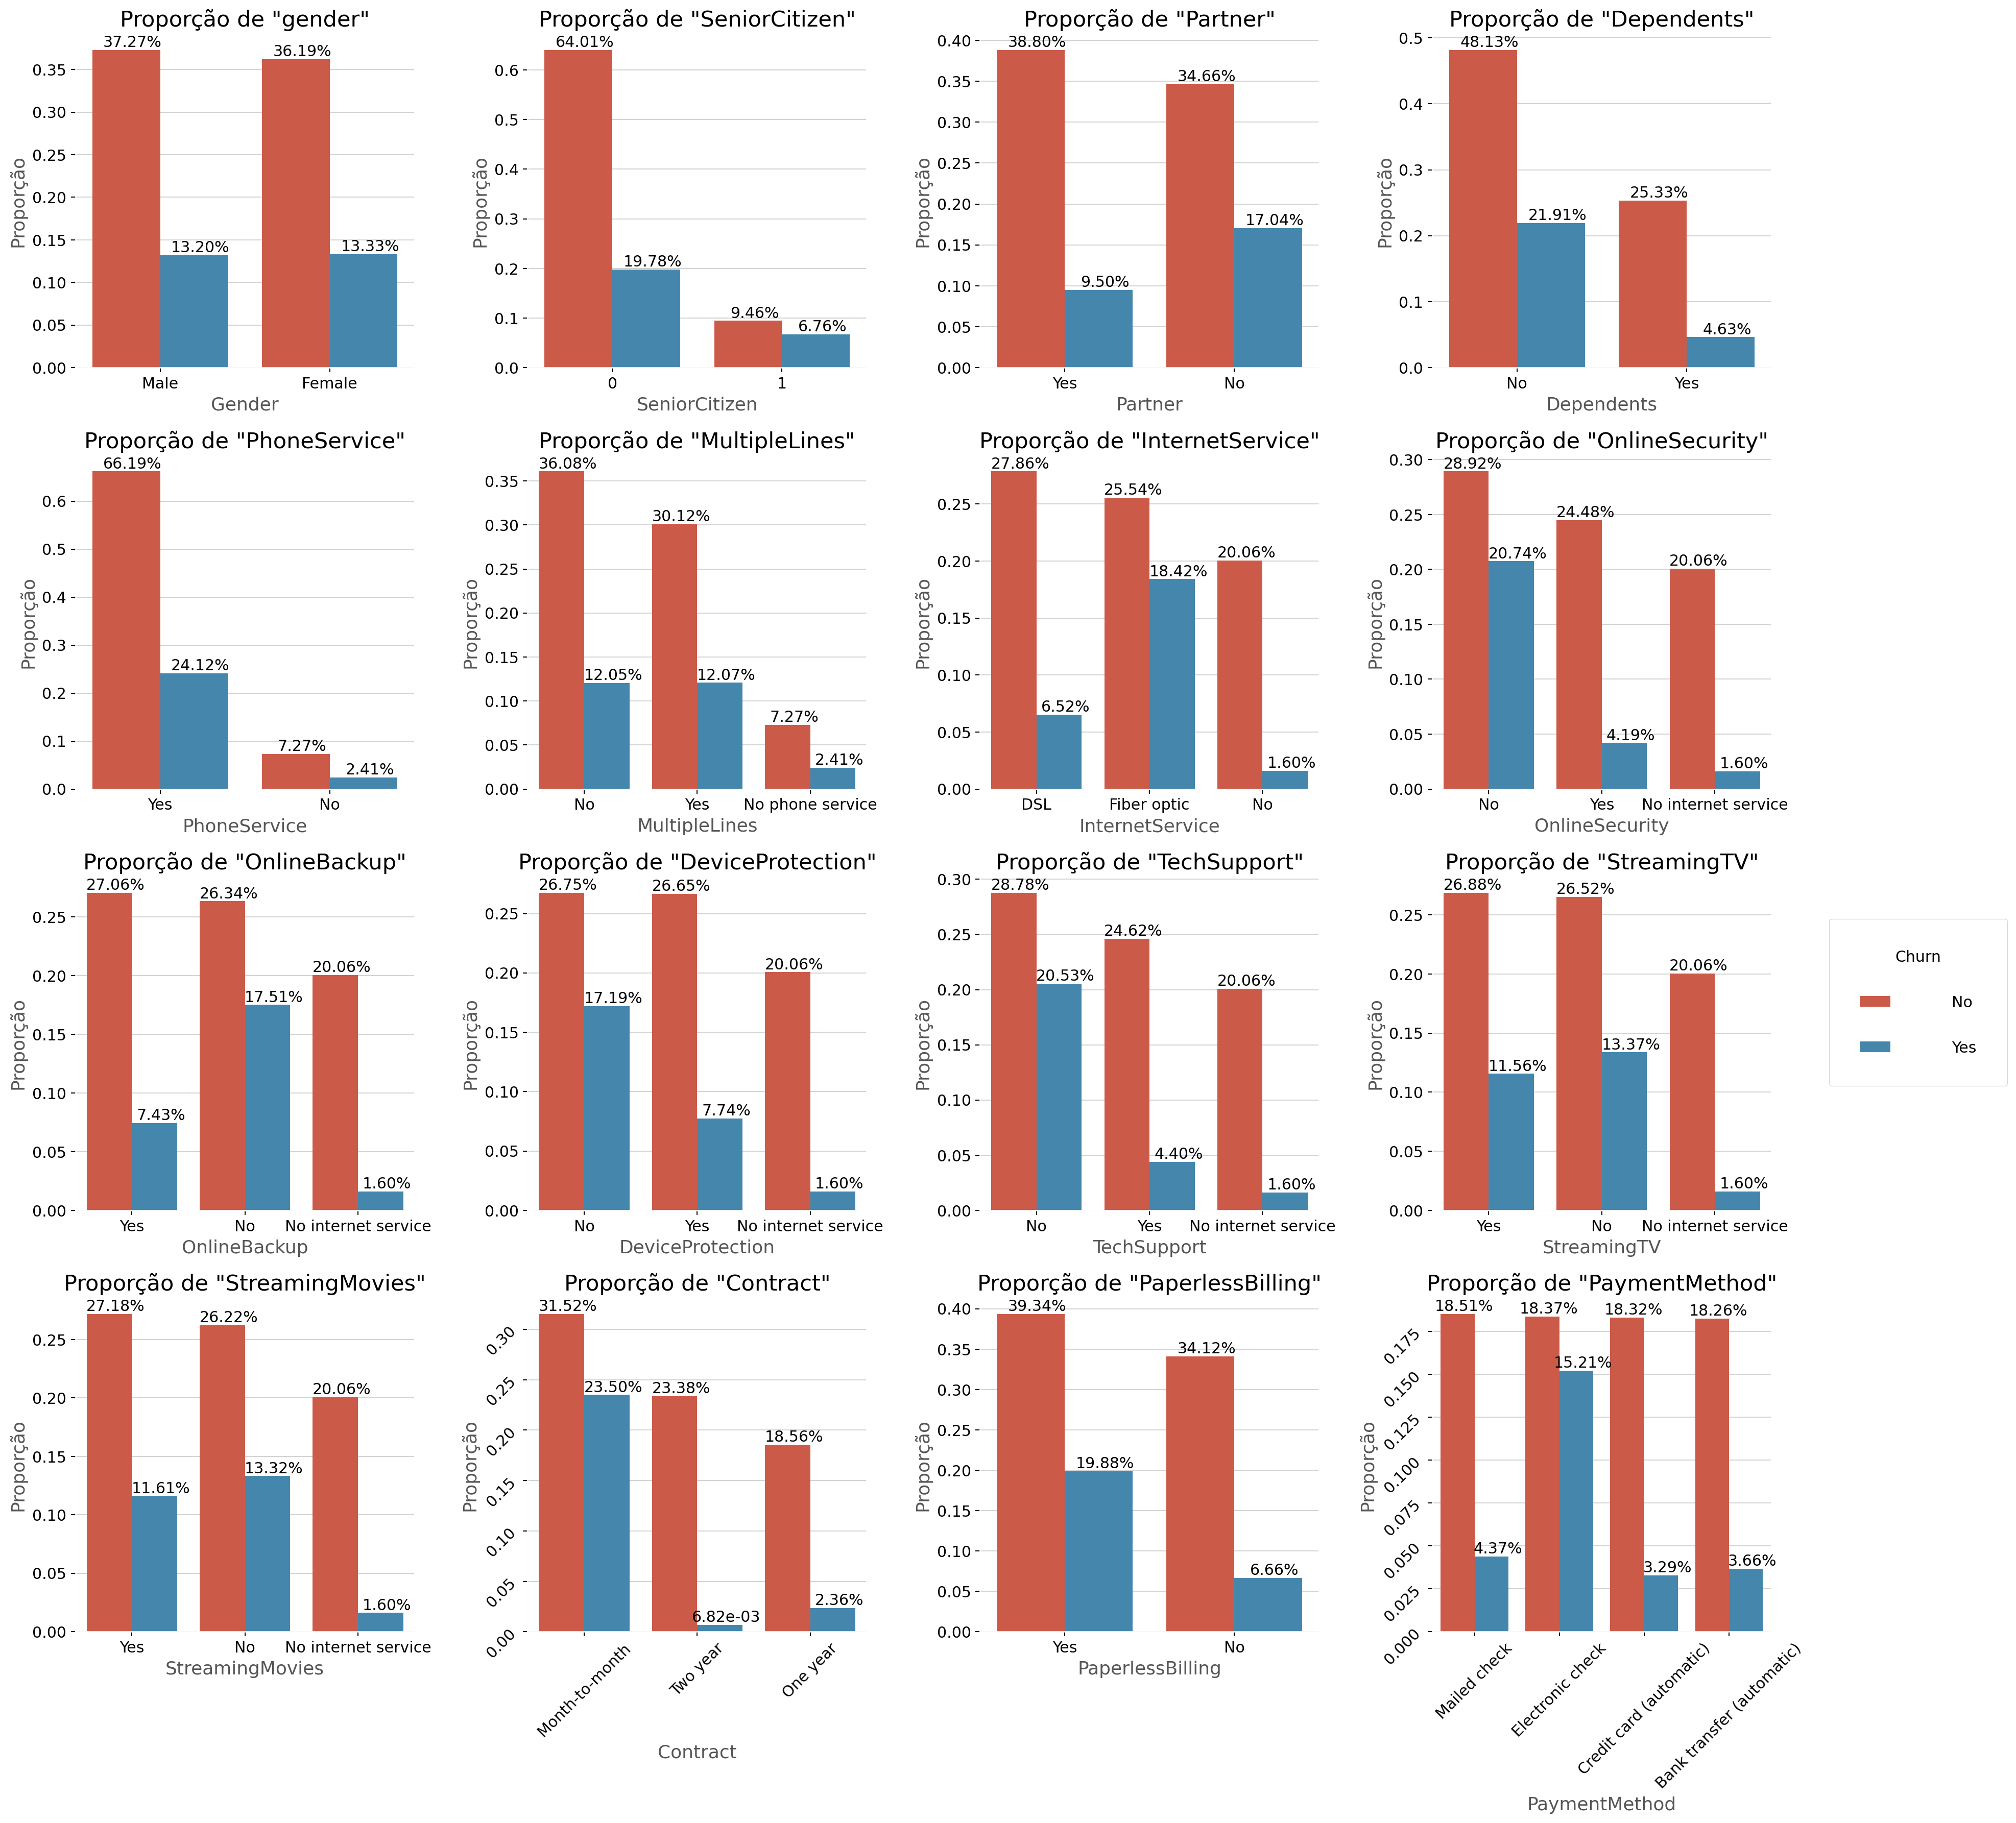

In [257]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
ax = ax.flatten()

for i, col in enumerate(cols):
    sns.barplot(data=customers[[col, "Churn"]].value_counts(normalize=True).reset_index(), x=col, y="proportion", hue="Churn", ax=ax[i])
    ax[i].set_title(f'Proporção de "{col}"')
    ax[i].set_xlabel("".join([col[0].upper(), col[1:]]))
    ax[i].set_ylabel("Proporção")

    if col in ["PaymentMethod", "Contract"]:
        ax[i].tick_params(rotation=45)
    if i == 0:
        # Apenas no primeiro plot
        handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend_.remove()  # Remove a legenda de todos os plots
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1, 0.5), title="Churn", labelspacing=2, markerscale=1.5, handletextpad=4, borderpad=2)

set_annotate(fig=fig, porcentages=True)

plt.tight_layout()
plt.show()



<h4>Observações: </h4>
<ul> 
    <li>Entre os idosos a proporção de churn parece ser bem mais significativa</li>
    <li>A proporção de churn para os clientes que não são casados é maior em comparação aos que são</li>  
    <li>A proporção de churn para os clientes que não possuem dependentes é maior em comparação aos que não tem</li>
    <li>A proporção de churn em relação ao serviço de fibra óptica é estranhamente alta se comparada ao outros serviços de internet, isso pode indicar que a empresa está tendo problemas em prever esse serviço de forma adaquada, o que gera atrito e consequentemente o churn do cliente insatisfeito</li>
    <li>No geral, parece que os clientes que não assinam por mais serviços, excetuando serviços de internet, tendem a dar mais churn</li>
    <li>A proporção de churn entre os clientes que optam por um contrato mensal é muito maior se comparado com os outros tipos de contrato, sendo que a proporção de churn tende a diminuir conforme o aumento do tempo de contrato</li>  
    <li>Clientes que optam por faturas desmaterializadas tem maior proporção de churn</li>
    <li>Clientes que optam pela fatura eletrônica tem proporções bem maiores de churn</li>  
</ul>

# Principais Conclusões da Análise Exploratória


<ul> 
    <li>A taxa de churn é significativa, com pouco mais de 1/4 dos clientes tendendo a dar churn.</li>
    <li>Metade dos clientes têm até 29 meses com a empresa, e até 50% dos clientes churn deixam a empresa por volta do décimo mês.</li>
    <li>25% dos clientes têm cobranças totais superiores a 3800, enquanto metade tem até 1400. As cobranças mensais são maiores entre os clientes churn, com mediana de aproximadamente U$ 75.</li>
    <li>Quase 84% dos clientes não são idosos, mas a proporção de churn entre idosos é significativamente maior.</li>
    <li>A maioria dos clientes não são casados e não possuem dependentes, e ambos os grupos apresentam maior proporção de churn comparado aos casados e aqueles com dependentes.</li>
    <li>Mais de 90% dos clientes possuem serviço de telefone, e clientes com serviço de fibra óptica têm uma proporção de churn estranhamente alta.</li>
    <li>Mais da metade dos clientes optam por contratos mensais, que apresentam uma proporção de churn significativamente maior em comparação com contratos de maior duração.</li>
    <li>Clientes que optam por faturas desmaterializadas e eletrônicas têm maior proporção de churn.</li>
</ul>

# Modelagem

Vou optar por testar diferentes grupos de modelos, lineares e os baseados em árvore, aplicando tratamento diferente as features baseado no comportamento de cada grupo de modelos

<br>
Separação de variáveis independes e variável dependente(transformada em númerica): 

In [258]:
X = customers.drop(["Churn"], axis=1)
y = customers["Churn"].map({"Yes":1, "No":0})

Aplicando Hold-out:

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [260]:
categoricas_binarias = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]

categoricas_n_arias = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                         "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

numericas = ["tenure", "MonthlyCharges", "TotalCharges"]

In [261]:
categoricas_binarias_transformer_linear = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("binary", BinaryEncoder())
])

categoricas_n_arias_transformer_linear = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("target", WOEEncoder())
])

numericas_transformer_linear = Pipeline(steps=[
    ("num_imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

preprocessor_linear = ColumnTransformer(transformers=[
    ("cat_binaria", categoricas_binarias_transformer_linear, categoricas_binarias),
    ("cat_n_arias", categoricas_n_arias_transformer_linear, categoricas_n_arias),
    ("num", numericas_transformer_linear, numericas)
])

Optei por normalizar as variáveis numéricas pois modelos lineares assumem que ela existe, e lidam muito melhor com dados que se comportam assim

In [262]:
modelos_lineares = [LogisticRegression(random_state=42),  
                    SVC(probability=True, random_state=42), 
                    KNeighborsClassifier()]

In [263]:
scores_modelos_lineares = validacao_cruzada(X, y, 5, preprocessor_linear, modelos_lineares, return_df=True)

In [264]:
scores_modelos_lineares.sort_values(by="Recall médio", ascending=False)

,Acurácia média,Precisão média,Recall médio,F1-Score médio,ROC-AUC-Score médio,Log Loss
LogisticRegression,0.804909,0.656872,0.553208,0.600438,0.845175,7.031797
KNeighborsClassifier,0.768847,0.573288,0.503994,0.536255,0.774637,8.331599
SVC,0.801644,0.673612,0.489536,0.566789,0.795881,7.149473


Optei por organizar os modelos pelo Recall médio pois essa métrica nos ajuda a enxergar bem, quem dos churns, o modelo realmente acertou

In [265]:
categoricas_binarias_transformer_arvore = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", BinaryEncoder())
])

categoricas_n_arias_transformer_arvore = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", TargetEncoder())
])


numericas_transformer_arvore = Pipeline(steps=[
    ("num_imputer", SimpleImputer(strategy="median")
     )
])

preprocessor_arvore = ColumnTransformer(transformers=[
    ("cat_binaria", categoricas_binarias_transformer_arvore, categoricas_binarias),
    ("cat_n_arias", categoricas_n_arias_transformer_arvore, categoricas_n_arias),
    ("num", numericas_transformer_arvore, numericas)
])

Como os modelos de árvore não necessitam de normalização, optei por deixar apenas o simple imputer no transformer de variáveis numéricas

Evitei utilizar encoders que aumentassem a dimensionalidade, pois para modelos de árvore isso pode ser bastante danoso

In [266]:
modelos_de_arvore = [RandomForestClassifier(random_state=42), 
           DecisionTreeClassifier(random_state=42), 
           XGBClassifier(random_state=42), 
           LGBMClassifier(force_col_wise=True, verbose=0, random_state=42), 
           CatBoostClassifier(verbose=0, random_state=42)]

In [267]:
scores_modelos_arvore = validacao_cruzada(X, y, 5, preprocessor_arvore, modelos_de_arvore, return_df=True)

In [268]:
scores_modelos_arvore.sort_values(by="Recall médio", ascending=False)

,Acurácia média,Precisão média,Recall médio,F1-Score médio,ROC-AUC-Score médio,Log Loss
LGBMClassifier,0.796391,0.640560,0.529668,0.579552,0.834603,7.338812
XGBClassifier,0.786737,0.614754,0.527542,0.567600,0.822826,7.686769
CatBoostClassifier,0.797527,0.648931,0.515752,0.574399,0.839321,7.297872
DecisionTreeClassifier,0.725114,0.482811,0.497032,0.489633,0.653565,9.907891
RandomForestClassifier,0.788723,0.632277,0.485797,0.549371,0.820661,7.615189


Impressionantemente os modelos de árvore, especialmente LGBM, XGB, e CatBoost foram batidos pela regressão logística. Por isso, vamos escolher esse modelo para tunar.

In [269]:
pipe = Pipeline(steps=[
                ("preprocessor", preprocessor_linear),   
                ("classifier", LogisticRegression())
            ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_binaria',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('cat_n_arias',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')...
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier', LogisticRegression())])

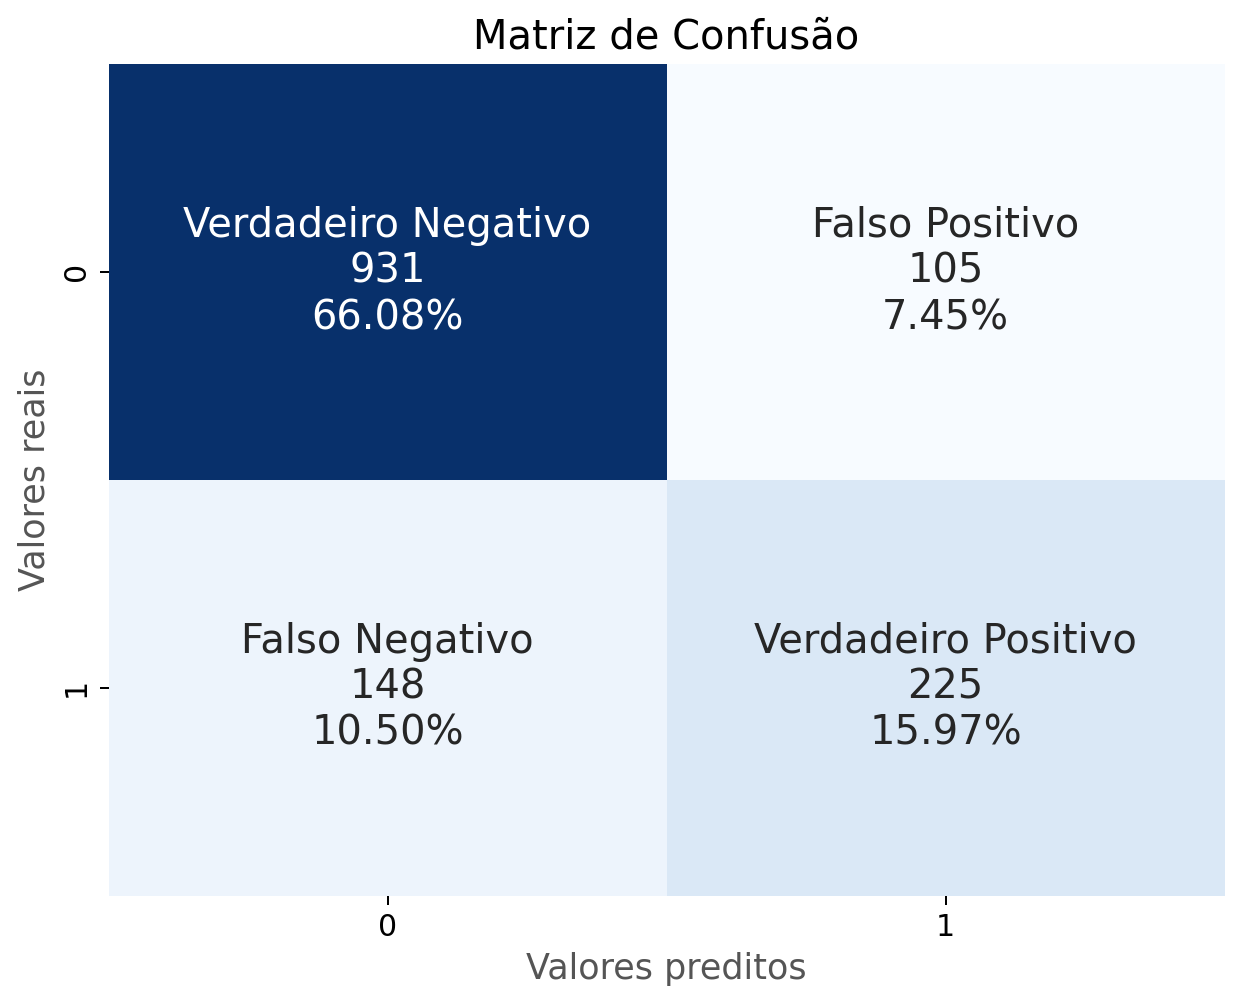

In [270]:
matriz_de_confusão(pipe, X_test, y_test)

In [271]:
y_pred = pipe.predict(X_test)

print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%} \n")


Acurracy score: 82.04%
Precision Score: 68.18%
Recall Score: 60.32%
F1 Score: 64.01%
LogLoss: 6.472
ROC AUC Score: 75.09% 



As métricas não são surpreendentes, e podem ser facilmente levantadas pela seleção correta de hiperparâmetros do modelo, passo que irá ser executado logo abaixo com auxílio do incrível framework <a href="https://optuna.org/">Optuna</a>

## Tunagem de hiperparâmetros

Optei por tunar a regressão logística através da Bayesian search, método sofitsticado que equilibra automaticamente a exploração de novas áreas do espaço de hiperparâmetros com a exploração de áreas que já demonstraram ser eficientes, melhorando então, a probabilidade de encontrar hiperparâmetros eficientes com menos avaliações, economizando tempo e recurso

In [272]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_loguniform("C", 1e-6, 1e2)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"])
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1) if penalty == "elasticnet" else None
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    tol = trial.suggest_loguniform("tol", 1e-6, 1e-2)  

    # Evitar combinações inválidas de penalidade e solver
    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "elasticnet" and solver != "saga":
        raise optuna.exceptions.TrialPruned()
    if penalty == "l2" and solver not in ["liblinear", "saga", "lbfgs", "newton-cg"]:
        raise optuna.exceptions.TrialPruned()

    weight_0 = trial.suggest_float("0", 0.5, 1.0)
    weight_1 = trial.suggest_float("1", 1.0, 2)
    class_weight = {0: weight_0, 1: weight_1}


    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter = max_iter,
        tol=tol,
        class_weight= class_weight,  
        random_state=42
    )

    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor_linear),
        ("classifier", model)
    ])

    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        f1 = f1_score(y_test, y_pred) 
        f1_scores.append(f1)

    return np.mean(f1_scores)



Nesse caso, escolhi atualizar os hiperparâmetros baseado no F1-Score pois ele é uma métrica combinada de precisão e recall, o  que ajudaria a equiblibrar as classificações, algo necessário devido ao custo que se tem com FP(Custos desnecessários com retenção) e FN(Perda de receita)

Como a regressão logística é bem menos complexa, e por tanto, menos computacionalmente custosa do que, por exemplo, os modelos ensemble também testados mais acima, isso nos permite selecionar um número maior de "trials" objetivando uma aquisição realmente eficiente de bons hiperparâmetros para o modelo

In [286]:
study = optuna.create_study(direction='maximize', sampler=TPESampler()) 
study.optimize(objective, n_trials=350, n_jobs=3)

[I 2024-06-30 16:07:11,074] A new study created in memory with name: no-name-d340f5ce-bf10-42b1-b02d-75acc164eae1
[I 2024-06-30 16:07:11,079] Trial 0 pruned. 
[I 2024-06-30 16:07:11,087] Trial 3 pruned. 
[I 2024-06-30 16:07:14,198] Trial 1 finished with value: 0.5763198908076224 and parameters: {'penalty': 'l1', 'C': 0.0007475081273767202, 'solver': 'liblinear', 'max_iter': 684, 'tol': 2.8056618804648283e-05, '0': 0.6343828384065908, '1': 1.714923997107316}. Best is trial 1 with value: 0.5763198908076224.
[I 2024-06-30 16:07:14,427] Trial 2 finished with value: 0.60080284870088 and parameters: {'penalty': 'l2', 'C': 0.0004945258114627046, 'solver': 'saga', 'max_iter': 849, 'tol': 0.00010029166549509885, '0': 0.5891191473679094, '1': 1.7627839602526771}. Best is trial 2 with value: 0.60080284870088.
[I 2024-06-30 16:07:14,694] Trial 4 finished with value: 0.5946605803655056 and parameters: {'penalty': 'l2', 'C': 0.00023219412918569986, 'solver': 'saga', 'max_iter': 151, 'tol': 1.9815778

In [287]:
best_params_dict = {k: v for k, v in study.best_params.items() if k not in ["0", "1"]} | {"class_weight": {0: study.best_params["0"], 1: study.best_params["1"]}}


Melhores hiperparâmetros: {'penalty': 'elasticnet', 'C': 0.01524385772174359, 'solver': 'saga', 'l1_ratio': 0.08205450828662966, 'max_iter': 275, 'tol': 8.279742790892285e-05, 'class_weight': {0: 0.8113543229686374, 1: 1.4959415659289235}}


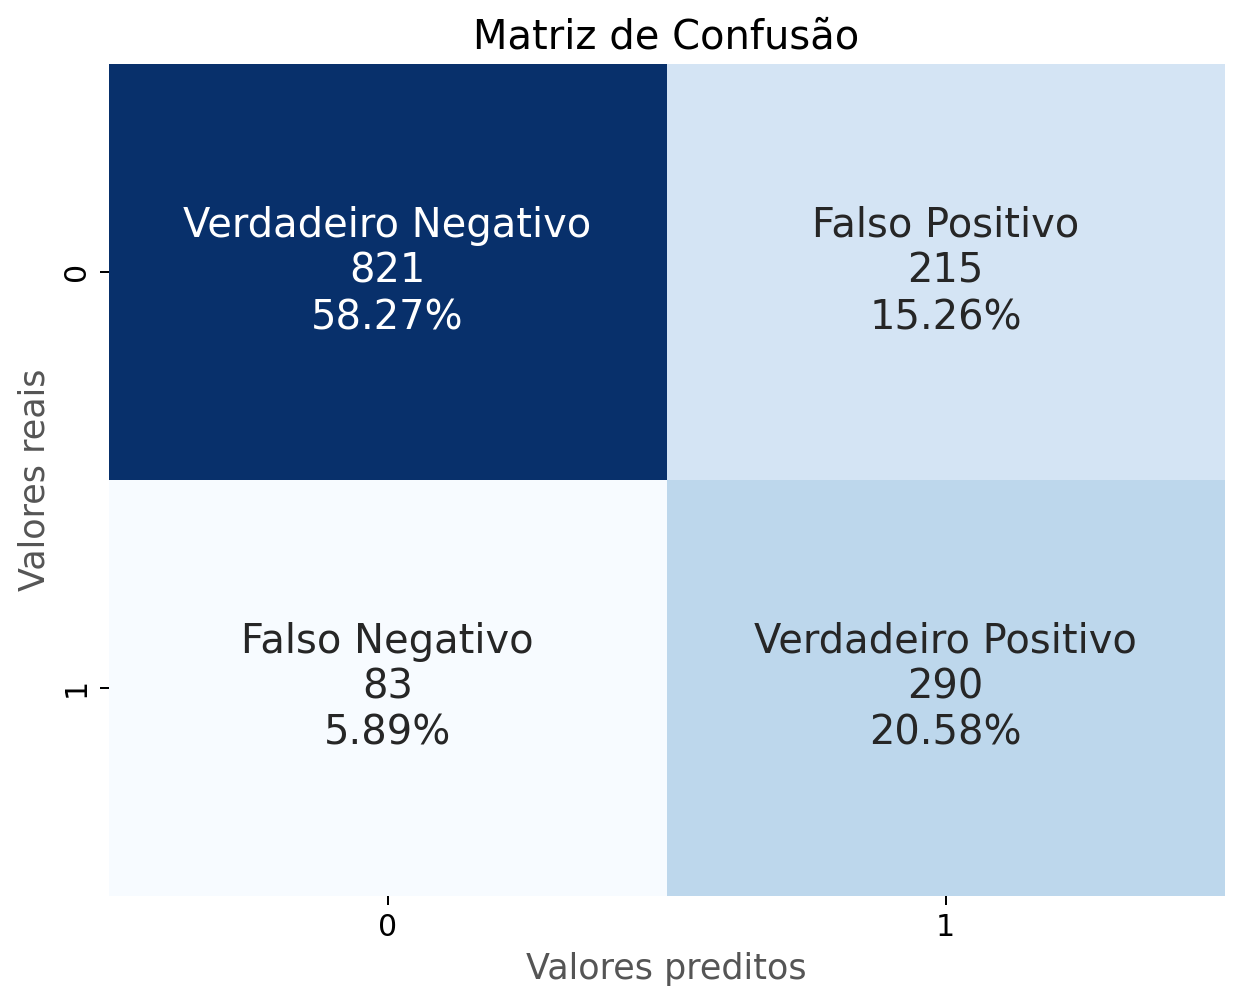

In [288]:
print("Melhores hiperparâmetros:", best_params_dict)

pipe = Pipeline(steps=[
                ("preprocessor", preprocessor_linear),   
                ("classifier", LogisticRegression(**best_params_dict))
            ])

pipe.fit(X_train, y_train)


matriz_de_confusão(pipe, X_test, y_test)

In [290]:
y_pred = pipe.predict(X_test)

print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%} \n")


Acurracy score: 78.85%
Precision Score: 57.43%
Recall Score: 77.75%
F1 Score: 66.06%
LogLoss: 7.6231
ROC AUC Score: 78.50% 



<hr>

Temos então

- Acurracy score: 78.85%
- Precision Score: 57.43%
- Recall Score: 77.75%
- F1 Score: 66.06%
- LogLoss: 7.6231
- ROC AUC Score: 78.50% 

Isso significa que a regressão logística avaliou dos que eram churn, 76.68% corretamente, e 57.09% dos casos em avaliados em churn no geral.

<hr>

Mas qual das características dos usuários foram fundamentais para se chegar a esse resultado? O quanto cada feature impactou na predição? Para responder essas perguntas, vou fazer o uso da biblioteca <a href="https://shap.readthedocs.io/en/latest/#">SHAP</a>, criada para explicação de modelos de machine learning.

# Interpretando o modelo

In [291]:
preprocessor = pipe.named_steps["preprocessor"]

# Nesse caso não é necessidade de utilizar o fit_transform, já que o preprocessor já treinou com pipe.fit
X_train_transformed = preprocessor.transform(X_train)

feature_names = preprocessor.get_feature_names_out()

# Renomeando features para facilitar a interpretação 
renamed_columns = []
for col in feature_names:
    if col.startswith("cat_binaria__"):
        index = int(col.split("__")[1].split("_")[0])
        sub_index = col.split("_")[-1]
        renamed_columns.append(f"{categoricas_binarias[index]}_{sub_index}")
    elif col.startswith("cat_n_arias__"):
        index = int(col.split("__")[1])
        renamed_columns.append(categoricas_n_arias[index])
    elif col.startswith("num__"):
        index = numericas.index(col.split("__")[1])
        renamed_columns.append(numericas[index])
    else:
        renamed_columns.append(col)

# Treinando regressão logística com os melhores hiperparâmetros e com dados de treino transformados pelo preprocessor
model = LogisticRegression(**best_params_dict)
model.fit(X_train_transformed, y_train)

# Objeto shap que auxilia nas explicações das predições
explainer = shap.Explainer(model, X_train_transformed, feature_names=renamed_columns)

X_test_transformed = preprocessor.transform(X_test)
shap_values = explainer(X_test_transformed)


X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=renamed_columns)


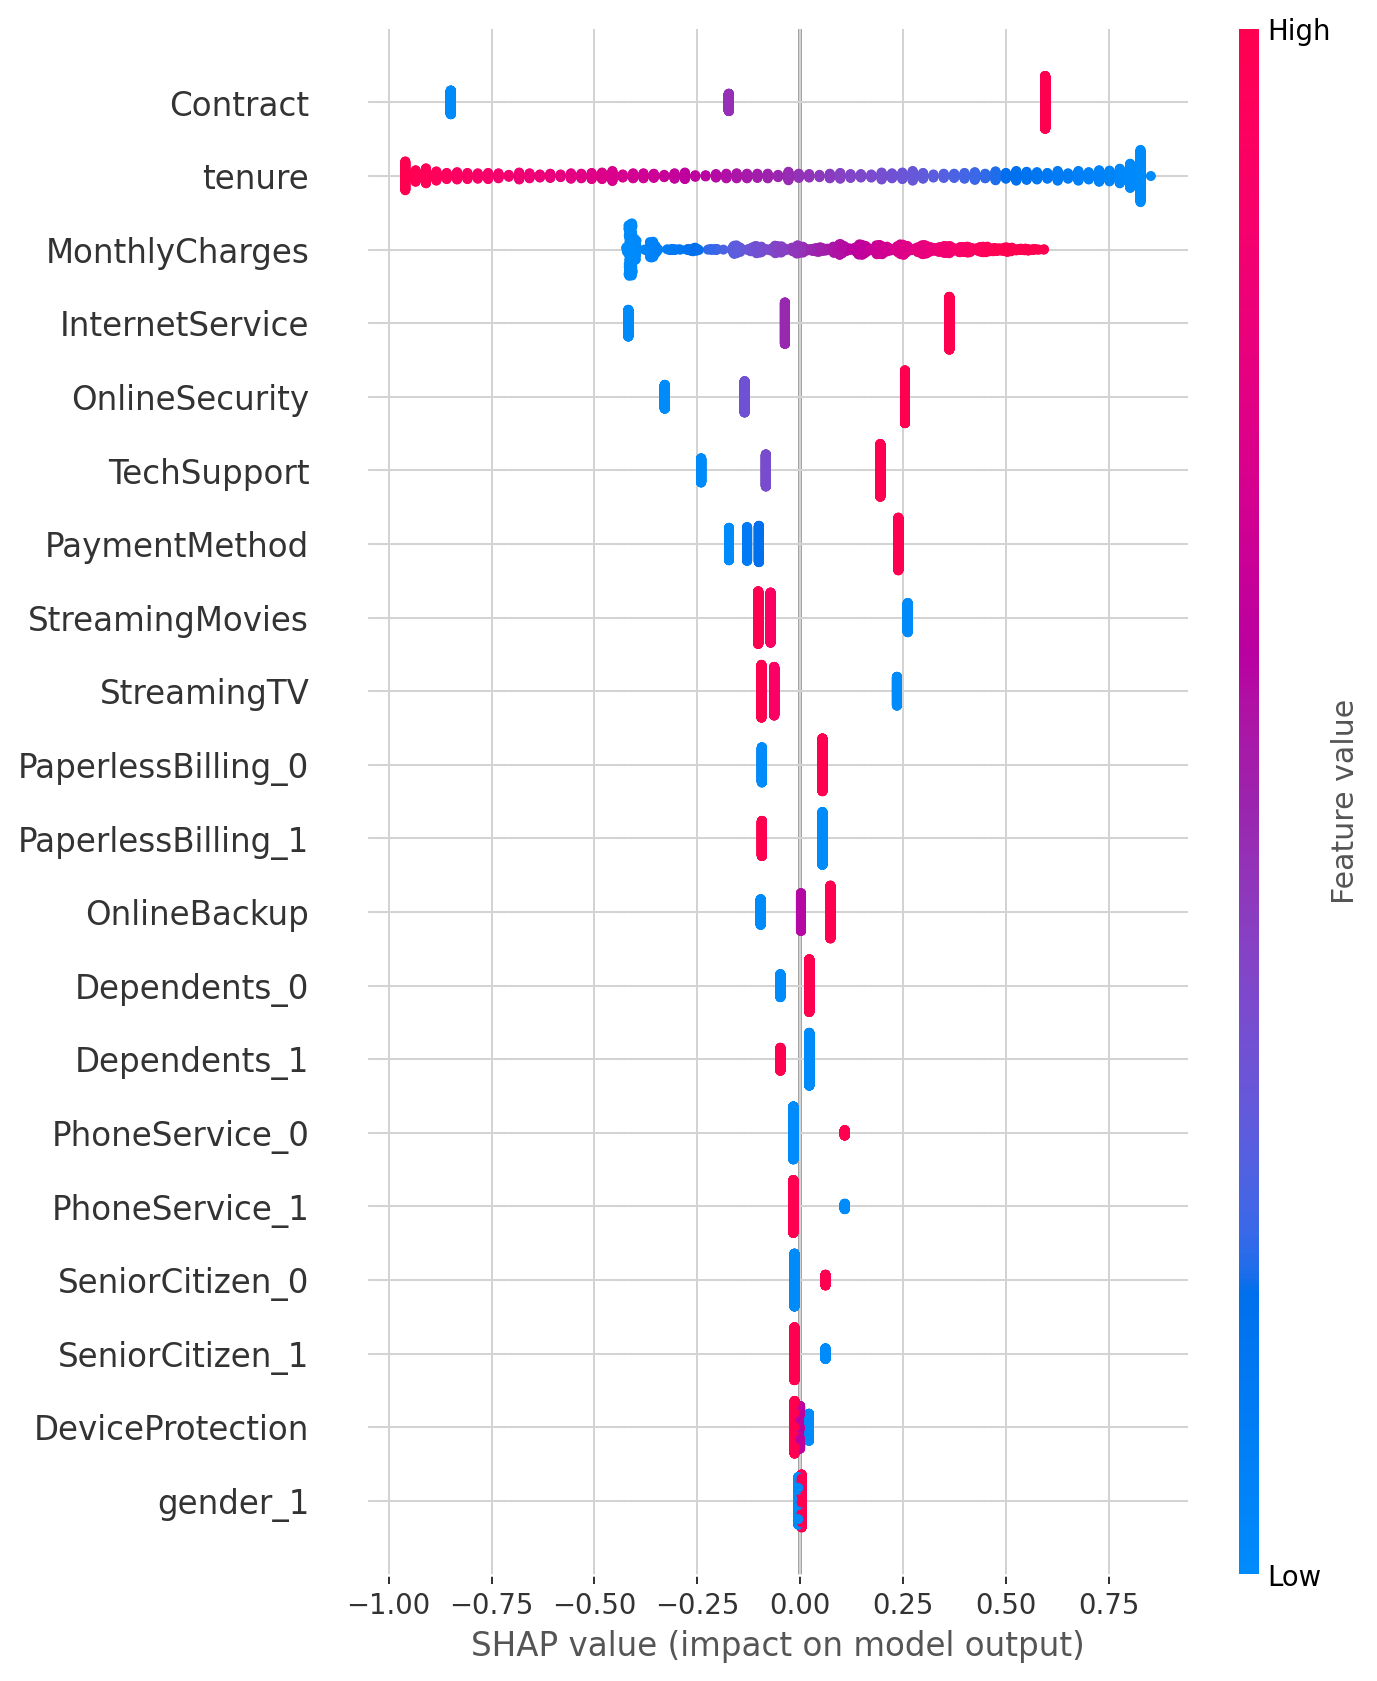

In [292]:
shap.summary_plot(shap_values, X_test_transformed_df)

<h4>Observações: </h4>
<ul> 
    <li>Podemos perceber que a característica mais importante nesse caso é a tenure, ou seja, a quantidade de meses que o cliente está com a empresa</li>
    <li>Para longos períodos de permanência, a probabilidade de churn tende a diminuir</li>  
    <li>Quanto maior as cobranças mensais e totais, maior a probabilidade de churn</li>
</ul>

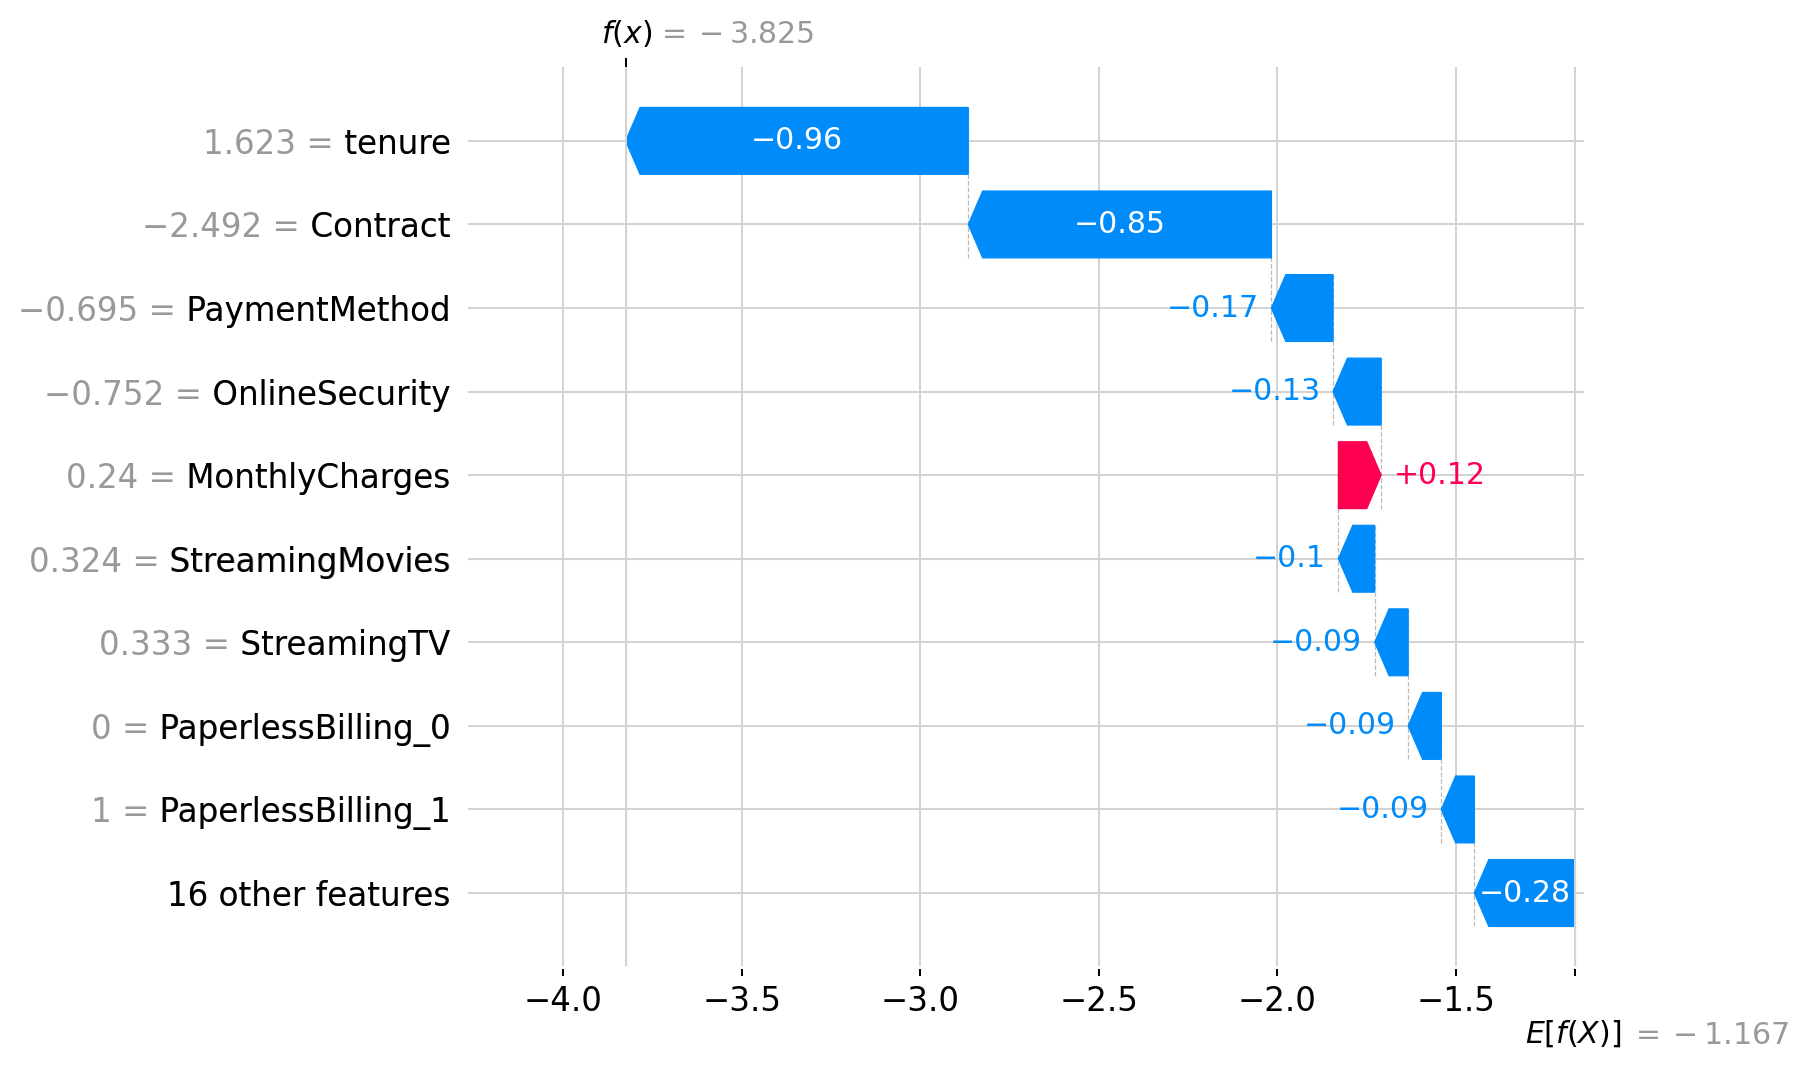

In [300]:
shap.plots.waterfall(shap_values[7])

<h4>Observações: </h4>
<ul> 
    <li>Nesse caso, temos que o modelo avalia esse usuário com apenas 2,1% de chance de ser churn</li>
    <li>A quantidade de meses que o cliente está com a empresa é extremamente importante para definir se esse cliente em específico é ou não churn</li>  
    <li>Semelhante ao summary plot, para esse cliente grandes taxas mensais contribuiram para chances de churn</li>
    <li>Apesar das features tenure e total charges contribuirem para o churn de forma semelhante a vista no summary plot, é importante ressaltar que isso não pode ser realidade para todos os casos. O summary plot dá uma visão global, considerando todos os clientes, enquanto o waterfall dá uma visão mais específca, local, de um único cliente, que pode ser influenciado de forma diferente pelas características</li>
</ul>


## Alterando treshold do modelo

Para além da tunagem de hiperparâmetros, podemos modificar o desempenho do nosso modelo alterando o seu treshold, que por padrão é 0.5. Abaixo, testarei alguns modelos com tresholds diferentes, variando de 0.70 a 0.40

Diminuir o treshold pode ser bom dependendo do cenário, ao se fazer isso, a margem de erro também aumenta, o que significa um maior custo pela solução, mas reteria mais clientes. Assim como, um treshold alto pode ser bom, o que pode aumentar o lucro líquido significativamente mas reteria bem menos clientes.

 Por esse motivo, vou incluir cada modelo testado abaixo na análise de negócio

In [301]:
class LogisticRegressionWithThreshold(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        probas = self.model.predict_proba(X)[:, 1]
        return (probas >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [302]:
for i in range(70, 39, -1):
    threshold = i / 100

    if threshold == 0.5:
        continue

    print("-="*20)
    print(f"THRESHOLD: | {threshold} |")
    
    model = LogisticRegressionWithThreshold(LogisticRegression(**best_params_dict), threshold=threshold)


    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)


    print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
    print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
    print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%}")

    #matriz_de_confusão(pipe, X_test, y_test)


-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.7 |
Acurracy score: 81.41%
Precision Score: 74.45%
Recall Score: 45.31%
F1 Score: 56.33%
LogLoss: 6.7022
ROC AUC Score: 69.85%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.69 |
Acurracy score: 81.69%
Precision Score: 73.66%
Recall Score: 47.99%
F1 Score: 58.12%
LogLoss: 6.5999
ROC AUC Score: 70.91%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.68 |
Acurracy score: 82.19%
Precision Score: 73.11%
Recall Score: 51.74%
F1 Score: 60.60%
LogLoss: 6.4208
ROC AUC Score: 72.44%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.67 |
Acurracy score: 82.11%
Precision Score: 71.84%
Recall Score: 53.35%
F1 Score: 61.23%
LogLoss: 6.4464
ROC AUC Score: 72.91%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.66 |
Acurracy score: 81.97%
Precision Score: 70.73%
Recall Score: 54.42%
F1 Score: 61.52%
LogLoss: 6.4976
ROC AUC Score: 73.16%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
THRESHOLD: | 0.65 |
Acurracy score: 82.1

# Análise de negócio

Após a identificação dos possíveis clientes que darão churn pelo modelo, uma medida terá de se para tentar retê-los. A solução que irei aplicar será a seguinte: 

<center><strong>-> Desconto de 20% nas cobranças dos próximos 6 meses <-</strong></center>

<br>

Assim, vamos considerar as seguintes variáveis envolvidas no retorno financeiro para a empresa:
- Desconto = 20% (0.20)
- Duração do Desconto = 3 meses
- Taxa de Retenção Através do Desconto = 50% (0.50)

<br>

Dessa forma, temos que os cálculos envolvidos na análise de negócio se dão por:
- Custo do Desconto = (TP+FP) × MonthlyCharges × Desconto × Durac​ão do Desconto

- Benefício do Desconto= TP × MonthlyCharges × (1−Desconto) × Duracão do Desconto × Taxa de Retencão 

- Retorno Líquido = Custo do Desconto - Benefício do Desconto

- Perda por Churns =  FN × MonthlyCharges × Duração do desconto



In [303]:
def retorno_fin(desconto=0.2, duracao=6, taxa_de_retencao=0.5, threshold=0.5):
    model = LogisticRegressionWithThreshold(LogisticRegression(**best_params_dict), threshold=threshold)

    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    resultado_fin = pd.concat([X_test, y_test], axis=1)[["MonthlyCharges", "Churn"]]
    resultado_fin["Churn_Pred"] = y_pred 

    tp_churn = resultado_fin[(resultado_fin.Churn == 1) & (resultado_fin.Churn_Pred == 1)].MonthlyCharges.sum()
    fp_churn = resultado_fin[(resultado_fin.Churn == 0) & (resultado_fin.Churn_Pred == 1)].MonthlyCharges.sum()

    fn_churn = resultado_fin[(resultado_fin.Churn == 1) & (resultado_fin.Churn_Pred == 0)].MonthlyCharges.sum()

    custo = (tp_churn + fp_churn) * desconto * duracao
    beneficio = tp_churn * (1-desconto) * duracao * taxa_de_retencao
    
    retorno_liquido = beneficio - custo

    perda = fn_churn *  duracao 


    print("-="*20)
    print(f"Modelo com {threshold} de treshold: \n")

    print(f"Recall Score: {recall_score(y_test,y_pred):.2f}%")

    print(f"CUSTO DO DESCONTO: U$ {custo:.2f}")
    print(f"BENEFÍCIO DO DESCONTO: U$ {beneficio:.2f}")
    print(f"RETORNO LÍQUIDO: U$ {retorno_liquido:.2f}")
    print(f"PERDA POR CHURNS NÃO CLASSIFICADOS: U$ {perda:.2f}")
    print("-="*20 + "\n")

Para a regressão logística após a tunagem de hiperparâmetros temos as métricas:
- Acurracy score: 78.85%
- Precision Score: 57.43%
- Recall Score: 77.75%
- F1 Score: 66.06%
- LogLoss: 7.6231
- ROC AUC Score: 78.50% 
						

In [304]:
retorno_fin(desconto=0.2, duracao=6, taxa_de_retencao=0.5, threshold=0.5)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.5 de treshold: 

Recall Score: 0.78%
CUSTO DO DESCONTO: U$ 46471.98
BENEFÍCIO DO DESCONTO: U$ 54663.00
RETORNO LÍQUIDO: U$ 8191.02
PERDA POR CHURNS NÃO CLASSIFICADOS: U$ 31209.00
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



É importante ressaltar que nesse caso estou usando uma taxa de retenção modesta, e que o foco em aumentar a taxa de retenção para essa solução deve ser presente 

Nesse cenário, temos que um aumento de 30% na taxa de conversão resulta em um aumento de mais de 410% no retorno líquido da empresa. Realmente impressionante. Vamos verificar isso abaixo:

In [305]:
retorno_fin(desconto=0.2, duracao=6, taxa_de_retencao=0.8, threshold=0.5)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.5 de treshold: 

Recall Score: 0.78%
CUSTO DO DESCONTO: U$ 46471.98
BENEFÍCIO DO DESCONTO: U$ 87460.80
RETORNO LÍQUIDO: U$ 40988.82
PERDA POR CHURNS NÃO CLASSIFICADOS: U$ 31209.00
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



## Análise do Trade-off entre Lucro Líquido e Perda por Churns Não Classificados



Um threshold alto significa que o modelo é mais conservador na classificação de churns, identificando apenas clientes com alta probabilidade predita de churn. Como mencionado anteriormente, diminuir o treshold pode ser bom dependendo do cenário, ao se fazer isso, a margem de erro também aumenta, o que significa um maior custo pela solução, mas reteria mais clientes. Assim como, um treshold alto pode ser bom, o que pode aumentar o lucro líquido significativamente mas reteria bem menos clientes


### Aumento de threshold
**Vantagens:**
- **Maior Precisão**: Menos falsos positivos, resultando em menos custos com descontos ou incentivos desnecessários.
- **Maior Lucro Líquido**: Redução de custos, especialmente se os incentivos são caros
- **Melhoria na Experiência do Cliente**: Evita descontos a clientes que não precisam, mantendo a percepção de valor dos serviços

**Desvantagens:**
- **Alta Perda por Churns Não Classificados**: Muitos deram churn sem serem identificados, resultando em perda significativa de receita
- **Impacto na Reputação**: Muitos clientes churnando sem intervenção podem afetar negativamente a reputação da empresa
- **Perda Significativa de Receita**: A perda por churns não classificados pode ser maior do que o benefício financeiro dos clientes retidos
- **Perda de Oportunidade**: Clientes churnados representam perda de receita imediata e potencial futura
- **Perda de participação no mercado**: Retenção inadequada pode resultar em perda de participação de mercado
- **Altos Custos de Aquisição de Clientes**: Perder clientes existentes é caro, especialmente com altos custos de aquisição
- **Mercado Competitivo**: Perder clientes para concorrentes pode ter impacto duradouro na marca

### Diminuição de threshold
Vantagens:
- **Maior Retenção de Clientes**: Identifica mais clientes que estão em risco de churn, permitindo intervenções que podem aumentar a retenção
- **Redução de Perda de Receita**: Menos clientes churnam sem serem identificados, resultando em menor perda de receita
- **Manutenção da Participação no Mercado**: Melhora a retenção de clientes, ajudando a manter ou aumentar a participação no mercado
- **Reforço da Reputação**: Intervenções mais frequentes podem melhorar a satisfação do cliente e a reputação da empresa
- **Aumento do Valor de Vida do Cliente**: Retenção de clientes por períodos mais longos aumenta o valor de vida do cliente, trazendo benefícios financeiros a longo prazo

Desvantagens:
- **Maior Custo com Descontos/Incentivos**: Mais falsos positivos significam mais clientes recebendo descontos ou incentivos desnecessários, aumentando os custos
- **Redução do Lucro Líquido**: Os custos aumentados com incentivos podem superar os benefícios de retenção, reduzindo o lucro líquido
- **Possível Erosão do Valor Percebido**: Oferecer descontos a muitos clientes pode levar à percepção de que o serviço/produto não vale o preço total
- **Gestão de Recursos**: Requer mais recursos para gerenciar e implementar intervenções para um maior número de clientes


In [307]:
for i in range(70, 39, -1):
    threshold = i / 100
    retorno_fin(desconto=0.2, duracao=6, taxa_de_retencao=0.5, threshold=threshold)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.7 de treshold: 

Recall Score: 0.45%
CUSTO DO DESCONTO: U$ 22616.58
BENEFÍCIO DO DESCONTO: U$ 33695.76
RETORNO LÍQUIDO: U$ 11079.18
PERDA POR CHURNS NÃO CLASSIFICADOS: U$ 83627.10
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.69 de treshold: 

Recall Score: 0.48%
CUSTO DO DESCONTO: U$ 24159.00
BENEFÍCIO DO DESCONTO: U$ 35591.40
RETORNO LÍQUIDO: U$ 11432.40
PERDA POR CHURNS NÃO CLASSIFICADOS: U$ 78888.00
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.68 de treshold: 

Recall Score: 0.52%
CUSTO DO DESCONTO: U$ 26152.62
BENEFÍCIO DO DESCONTO: U$ 38334.72
RETORNO LÍQUIDO: U$ 12182.10
PERDA POR CHURNS NÃO CLASSIFICADOS: U$ 72029.70
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.67 de treshold: 

Recall Score: 0.53%
CUSTO DO DESCONTO: U$ 27361.86
BENEFÍCIO DO DESCONTO: U$ 39374.28
RETORNO LÍQU